In [1]:
!pip install yfinance ta-lib pandas numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 33.7 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Download dataset
data = yf.download("AAPL", start="2018-01-01", end="2025-01-01")

# Preview
data.head()


/tmp/ipython-input-326188680.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.341888,40.351258,39.639313,39.850088,102223600
2018-01-03,40.334866,40.878192,40.271636,40.405124,118071600
2018-01-04,40.522205,40.625250,40.299724,40.407450,89738400
2018-01-05,40.983578,41.070228,40.526904,40.618239,94640000
2018-01-08,40.831348,41.126429,40.732985,40.831348,82271200


In [7]:
# FIX MULTI-INDEX COLUMNS FROM YFINANCE
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns]


In [8]:
print(data.columns)


Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL',
       'EMA_9_', 'EMA_20_'],
      dtype='object')


In [9]:
# rename close column to Close
close_col = [c for c in data.columns if "Close" in c][0]
data.rename(columns={close_col: "Close"}, inplace=True)

data['Close'] = data['Close'].astype(float)


In [10]:
data['EMA_9']  = data['Close'].ewm(span=9).mean()
data['EMA_20'] = data['Close'].ewm(span=20).mean()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/period).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/period).mean()
    rs = gain / loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])


In [11]:
# -------- FIX MULTI-INDEX --------###################################
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns]

# -------- FIND CLOSE COLUMN --------
close_col = [c for c in data.columns if "Close" in c][0]
data.rename(columns={close_col: "Close"}, inplace=True)

# -------- ENSURE 1D FLOAT SERIES --------
data['Close'] = data['Close'].astype(float)

# -------- INDICATORS --------
data['EMA_9'] = data['Close'].ewm(span=9).mean()
data['EMA_20'] = data['Close'].ewm(span=20).mean()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/period).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/period).mean()
    rs = gain / loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])

print(data[['Close', 'EMA_9', 'EMA_20', 'RSI']].tail())


                 Close       EMA_9      EMA_20        RSI
Date                                                     
2024-12-24  257.037506  250.935011  245.557887  75.750265
2024-12-26  257.853760  252.318761  246.728923  76.452840
2024-12-27  254.439224  252.742854  247.463237  67.626267
2024-12-30  251.064484  252.407180  247.806213  60.225567
2024-12-31  249.292496  251.784243  247.947764  56.715889


In [12]:
data['Signal'] = 0

# Buy
data.loc[
    (data['EMA_9'] > data['EMA_20']) &
    (data['EMA_9'].shift(1) <= data['EMA_20'].shift(1)) &
    (data['RSI'] > 50),
    'Signal'
] = 1

# Sell
data.loc[
    (data['EMA_9'] < data['EMA_20']) &
    (data['EMA_9'].shift(1) >= data['EMA_20'].shift(1)) &
    (data['RSI'] < 50),
    'Signal'
] = -1

data[['Close', 'EMA_9', 'EMA_20', 'RSI', 'Signal']].tail()


,Close,EMA_9,EMA_20,RSI,Signal
Date,,,,,
2024-12-24,257.037506,250.935011,245.557887,75.750265,0
2024-12-26,257.853760,252.318761,246.728923,76.452840,0
2024-12-27,254.439224,252.742854,247.463237,67.626267,0
2024-12-30,251.064484,252.407180,247.806213,60.225567,0
2024-12-31,249.292496,251.784243,247.947764,56.715889,0


In [13]:
#Convert signals to positions
data['Position'] = data['Signal'].replace(to_replace=0, method='ffill')


/tmp/ipython-input-327521407.py:1: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  data['Position'] = data['Signal'].replace(to_replace=0, method='ffill')


In [14]:
#Returns
data['Market_Return'] = data['Close'].pct_change()
data['Strategy_Return'] = data['Position'].shift(1) * data['Market_Return']


In [15]:
#Cumulative Returns
data['Cumulative_Market'] = (1 + data['Market_Return']).cumprod()
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod()


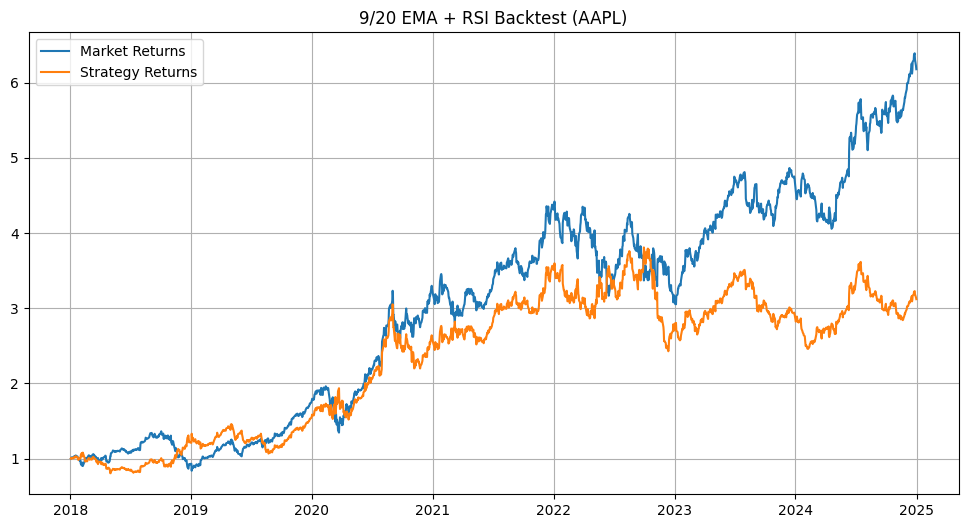

In [16]:
plt.figure(figsize=(12,6))
plt.plot(data['Cumulative_Market'], label='Market Returns')
plt.plot(data['Cumulative_Strategy'], label='Strategy Returns')
plt.title("9/20 EMA + RSI Backtest (AAPL)")
plt.legend()
plt.grid(True)
plt.show()


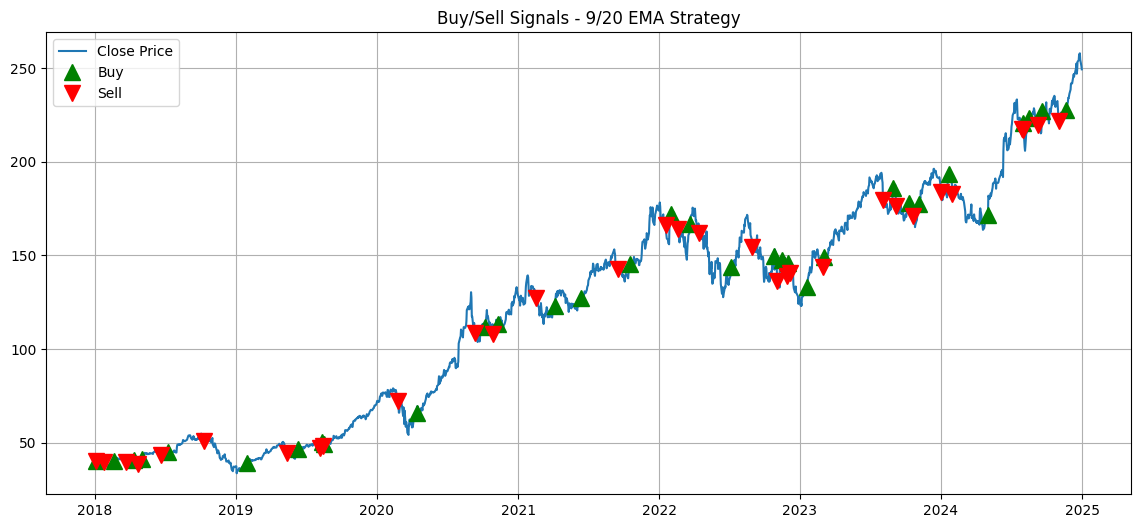

In [17]:
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label="Close Price")

# Buy Points
plt.plot(data.loc[data['Signal'] == 1].index,
         data['Close'][data['Signal'] == 1],
         '^', markersize=12, label='Buy', color='green')

# Sell Points
plt.plot(data.loc[data['Signal'] == -1].index,
         data['Close'][data['Signal'] == -1],
         'v', markersize=12, label='Sell', color='red')

plt.title("Buy/Sell Signals - 9/20 EMA Strategy")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
def calculate_metrics(df):
    total_return = df['Cumulative_Strategy'].iloc[-1] - 1
    max_drawdown = (df['Cumulative_Strategy'] / df['Cumulative_Strategy'].cummax() - 1).min()
    sharpe_ratio = np.sqrt(252) * df['Strategy_Return'].mean() / df['Strategy_Return'].std()

    return {
        "Total Return": f"{total_return*100:.2f}%",
        "Maximum Drawdown": f"{max_drawdown*100:.2f}%",
        "Sharpe Ratio": round(sharpe_ratio, 2)
    }

metrics = calculate_metrics(data)
metrics


{'Total Return': '212.05%',
 'Maximum Drawdown': '-36.27%',
 'Sharpe Ratio': np.float64(0.69)}